In [107]:
import msprime
import sys
import numpy as np
import seaborn as sns
from IPython.display import SVG
import matplotlib.pyplot as plt
from itertools import chain
from scipy.spatial import distance

Reference population consisits of two populations which diverge 50 generations in the past

In [108]:
pop_configs = [
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0),
    msprime.PopulationConfiguration(sample_size=100, growth_rate = 0),]

divergence_event1 = msprime.MassMigration(time = 50, source = 1, dest = 0, proportion = 1)
Ne = 100
recomb = 0.5
mutation_rate = 0.25
ts_ref = msprime.simulate(population_configurations = pop_configs,Ne = Ne,mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1],
                      random_seed = 1, recombination_rate = recomb)
pops = [range(0,100),range(100,200)]
ref_stats = (ts_ref.f2(pops),ts_ref.diversity(),ts_ref.segregating_sites(),ts_ref.Tajimas_D())

Tree sequences are generated with divergence time sampled from the prior - either exponenial or uniform

In [109]:
#ABC Function
def Ts_stat_generator(pop_configs,pops,Ne,recomb,mutations,prior ="exponential",prior_parameters=10,iters=1000):
    stats = [0]*iterations
    samples = [0]*iterations
    if prior == "exponential":
        for iter in range(0,iterations):
            divergence_time = min(np.random.exponential(prior_parameters),1000)
            divergence_event1 = msprime.MassMigration(time = divergence_time, source = 1, dest = 0, proportion = 1)
            ts_sim = msprime.simulate(population_configurations = pop_configs,Ne=Ne, mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1],recombination_rate = recomb)
            stats[iter]= [float(ts_sim.f2(pops)),float(ts_sim.diversity()),float(ts_sim.segregating_sites()),float(ts_sim.Tajimas_D())]
            samples[iter] = divergence_time
    if prior == "uniform":
        for iter in range(0,iterations):
            divergence_time = min(np.random.uniform(prior_parameters[0],prior_parameters[1]),1000)
            divergence_event1 = msprime.MassMigration(time = divergence_time, source = 1, dest = 0, proportion = 1)
            ts_sim = msprime.simulate(population_configurations = pop_configs,Ne=Ne, mutation_rate=mutation_rate,
                      demographic_events = [divergence_event1],recombination_rate = recomb)
            stats[iter]= (ts_sim.f2(pops),ts_sim.diversity(),ts_sim.segregating_sites(),ts_sim.Tajimas_D())
            samples[iter] = divergence_time
    return(stats,samples)

In [110]:
%%time
#Exponential prior rate 40 
iterations = 10000
prior= "exponential"
prior_parameters = 40
attempt1 = Ts_stat_generator(pop_configs=pop_configs,pops=pops,Ne=Ne,recomb=recomb,mutations=mutation_rate,prior=prior,prior_parameters=prior_parameters,iters=iterations)


Wall time: 2min 37s


Plots of each statistic give an idea of variance

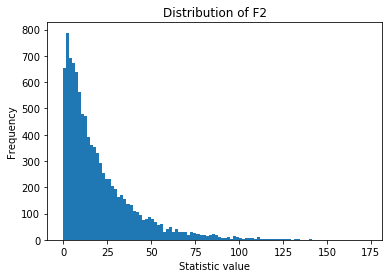

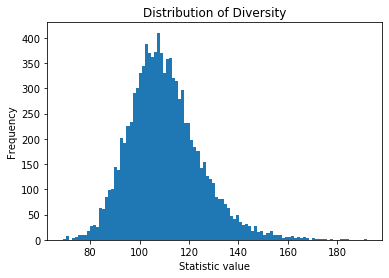

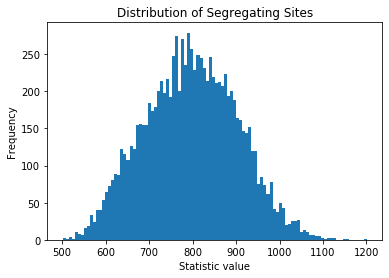

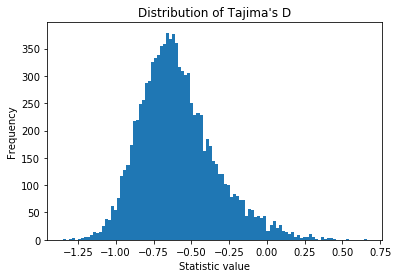

In [151]:
#Statistic Distributions
stat_names = ["F2","Diversity","Segregating Sites","Tajima's D"]
stat_matrix = np.array(attempt1[0]).T
for i in range(len(ref_stats)):
    plt.hist(stat_matrix[i], bins = 100)
    plt.ylabel('Frequency')
    plt.xlabel('Statistic value')
    plt.title('Distribution of '+stat_names[i])
    plt.show()

Rejection Sampling with a single statistic. $\epsilon$ is picked to keep 5-10% of samples. Each sample statistic is divided by the reference statistic

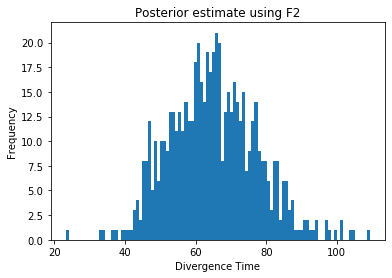

Acceptance probability : 0.0598


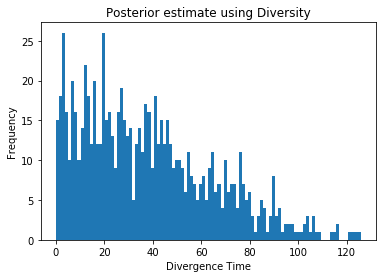

Acceptance probability : 0.0824


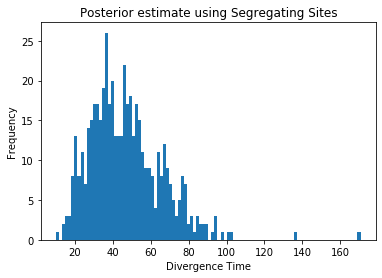

Acceptance probability : 0.0497


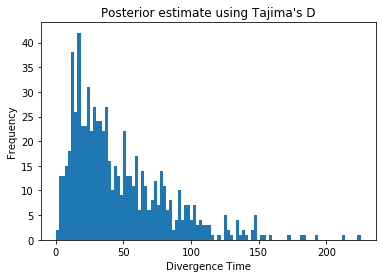

Acceptance probability : 0.0727


In [153]:
#Single Statistic Samples
stat_names = ["F2","Diversity","Segregating Sites","Tajima's D"]
eps = [3,1.5,8,0.02]
for i in range(len(ref_stats)):
    samples = []
    ref_stat = ref_stats[i]
    for j in range(iterations):
        sim_stat = attempt1[0][j][i]
        if np.linalg.norm(np.subtract(ref_stat,sim_stat)) < eps[i]:
            samples.append(attempt1[1][j])
    plt.hist(samples, bins = 100)
    plt.ylabel('Frequency')
    plt.xlabel('Divergence Time')
    plt.title('Posterior estimate using '+stat_names[i])
    plt.show()
    print("Acceptance probability :",len(samples)/iterations)

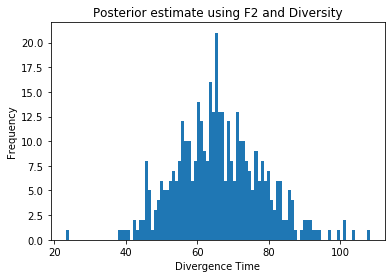

Acceptance probability : 0.0411


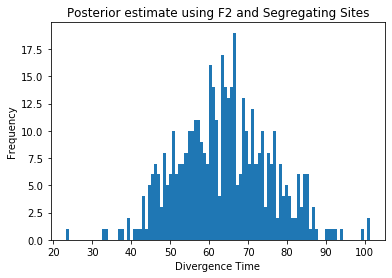

Acceptance probability : 0.0453


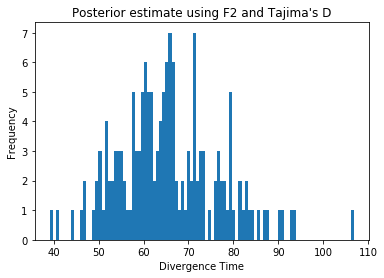

Acceptance probability : 0.0157


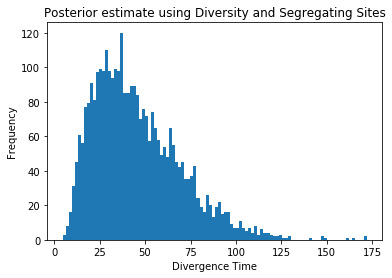

Acceptance probability : 0.3228


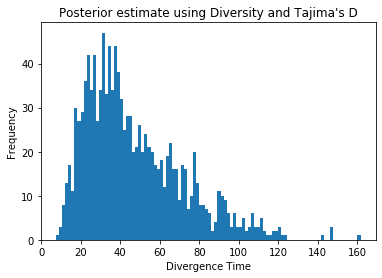

Acceptance probability : 0.1218


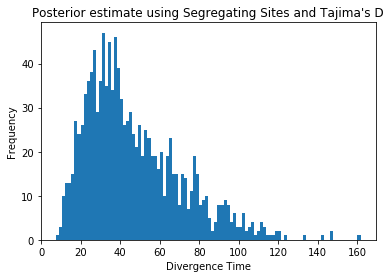

Acceptance probability : 0.1215


In [137]:
#Two Statistic Samples, eps = 0.1, standardised statistics
eps = 0.1
for i in range(len(ref_stats)):
    for j in range(i+1,len(ref_stats)):
        samples = []
        for iteration in range(iterations):
            sim_stat = (attempt1[0][iteration][i]/ref_stats[i],attempt1[0][iteration][j]/ref_stats[j])
            if np.linalg.norm(np.subtract(sim_stat,(1,1))) < eps:
                samples.append(attempt1[1][iteration])
        plt.hist(samples, bins = 100)
        plt.ylabel('Frequency')
        plt.xlabel('Divergence Time')
        plt.title('Posterior estimate using '+stat_names[i]+" and "+stat_names[j])
        plt.show()
        print("Acceptance probability :",len(samples)/iterations)

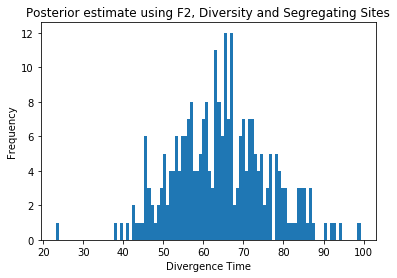

Acceptance probability : 0.0266


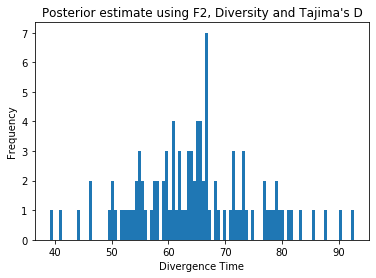

Acceptance probability : 0.01


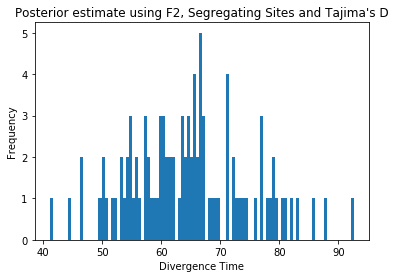

Acceptance probability : 0.0097


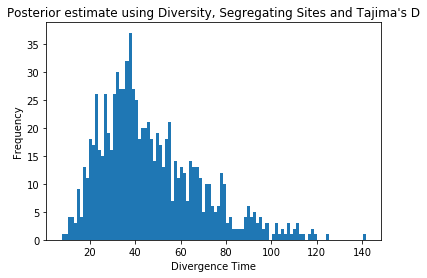

Acceptance probability : 0.0883


In [114]:
#Three Statistic Samples, eps = 0.1, standardised statistics
eps = 0.1
for i in range(len(ref_stats)):
    for j in range(i+1,len(ref_stats)):
        for k in range(j+1,len(ref_stats)): 
            samples = []
            for iteration in range(iterations):
                sim_stat = (attempt1[0][iteration][i]/ref_stats[i],attempt1[0][iteration][j]/ref_stats[j],attempt1[0][iteration][k]/ref_stats[k])
                if np.linalg.norm(np.subtract(sim_stat,(1,1,1))) < eps:
                    samples.append(attempt1[1][iteration])
            plt.hist(samples, bins = 100)
            plt.ylabel('Frequency')
            plt.xlabel('Divergence Time')
            plt.title('Posterior estimate using '+stat_names[i]+", "+stat_names[j]+" and "+stat_names[k])
            plt.show()
            print("Acceptance probability :",len(samples)/iterations)

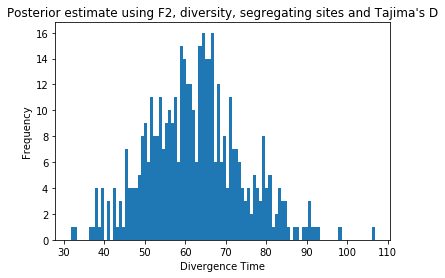

Acceptance probability : 0.0441


In [116]:
#4 Statistic Samples, eps = 0.1, standardised statistics
eps = 0.1
samples = []
for iteration in range(iterations):
    sim_stat = (attempt1[0][iteration][0]/ref_stats[0],attempt1[0][iteration][1]/ref_stats[1],attempt1[0][iteration][2]/ref_stats[2],attempt1[0][iteration][3]/ref_stats[3])
    if np.linalg.norm(np.subtract(sim_stat,(1,1,1,1))) < eps:
        samples.append(attempt1[1][iteration])
plt.hist(samples, bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Divergence Time')
plt.title("Posterior estimate using F2, diversity, segregating sites and Tajima's D")
plt.show()
print("Acceptance probability :",len(samples)/iterations)

# Implementing Mahalanobis Distance by using a sample covariance matrix

In [126]:
#Covariance of Statistics from pool of tree sequences
cov = np.cov(np.array(attempt1[0]).T)
print(cov)

[[ 7.82689009e-03 -1.03701657e-02  1.10064247e-04  2.89818590e-01]
 [-1.03701657e-02  5.59900253e-01 -7.80571120e-02 -2.20968065e+01]
 [ 1.10064247e-04 -7.80571120e-02  1.12222902e-02  3.11971612e+00]
 [ 2.89818590e-01 -2.20968065e+01  3.11971612e+00  8.92951426e+02]]
[[431.32925035 222.9836113 ]
 [222.9836113  207.68667133]]
[[ 4.31329250e+02  2.22983611e+02  1.79750479e+03 -9.02049269e-01]
 [ 2.22983611e+02  2.07686671e+02  1.17458125e+03  9.63352896e-01]
 [ 1.79750479e+03  1.17458125e+03  1.12390968e+04 -1.07836180e+01]
 [-9.02049269e-01  9.63352896e-01 -1.07836180e+01  6.29264687e-02]]


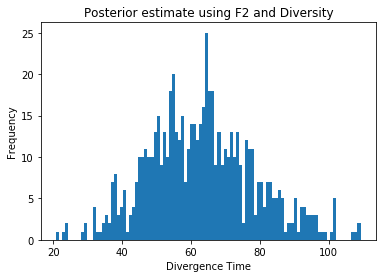

Acceptance probability : 0.0634


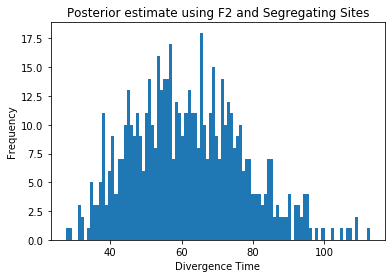

Acceptance probability : 0.0594


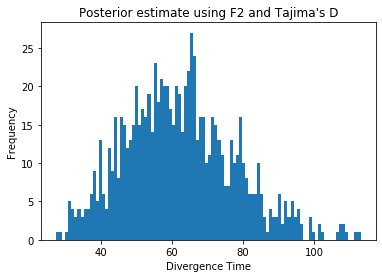

Acceptance probability : 0.0866


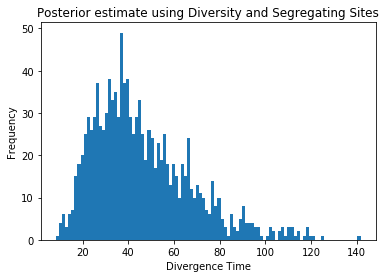

Acceptance probability : 0.1175


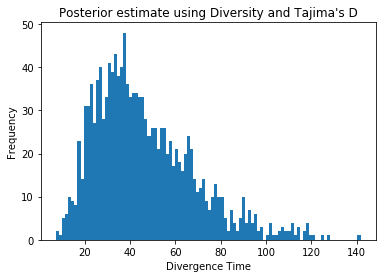

Acceptance probability : 0.1356


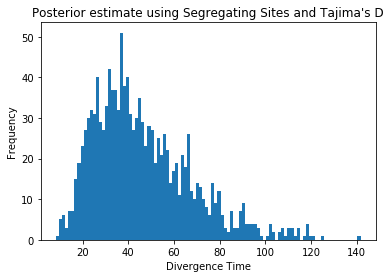

Acceptance probability : 0.1281


In [142]:
#Two Statistic Samples, Mahalanobis distance
eps = 0.5
for i in range(len(ref_stats)):
    for j in range(i+1,len(ref_stats)):
        samples = []
        cov_matrix = cov[np.ix_([i,j],[i,j])]
        for iteration in range(iterations):
            sim_stat = [attempt1[0][iteration][i],attempt1[0][iteration][j]]
            ref_stat = [ref_stats[i],ref_stats[j]]
            if distance.mahalanobis(sim_stat,ref_stat,np.linalg.inv(cov_matrix)) < eps:
                samples.append(attempt1[1][iteration])
        plt.hist(samples, bins = 100)
        plt.ylabel('Frequency')
        plt.xlabel('Divergence Time')
        plt.title('Posterior estimate using '+stat_names[i]+" and "+stat_names[j])
        plt.show()
        print("Acceptance probability :",len(samples)/iterations)

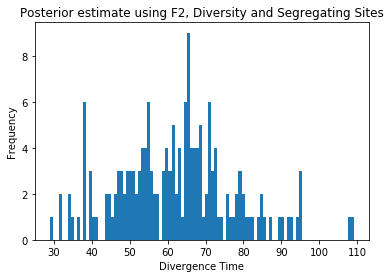

Acceptance probability : 0.0169


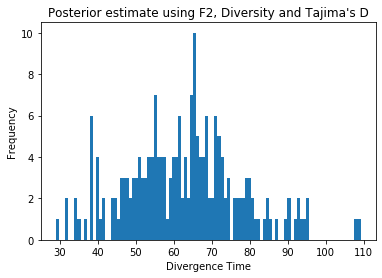

Acceptance probability : 0.02


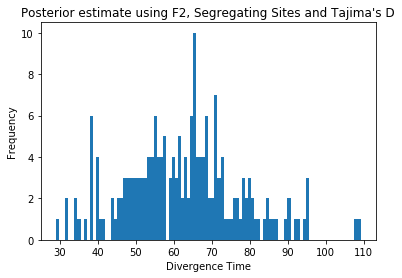

Acceptance probability : 0.0189


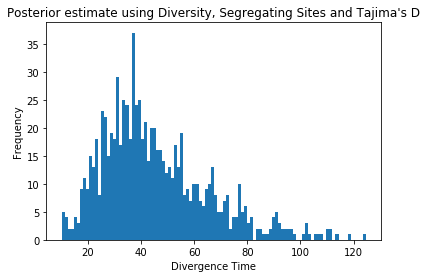

Acceptance probability : 0.0827


In [154]:
#Three Statistic Samples, Mahalanobis distance
eps = 0.5
for i in range(len(ref_stats)):
    for j in range(i+1,len(ref_stats)):
        for k in range(j+1,len(ref_stats)):  
            samples = []
            cov_matrix = cov[np.ix_([i,j,k],[i,j,k])]
            for iteration in range(iterations):
                sim_stat = [attempt1[0][iteration][i],attempt1[0][iteration][j],attempt1[0][iteration][k]]
                ref_stat = [ref_stats[i],ref_stats[j],ref_stats[k]]
                if  distance.mahalanobis(sim_stat,ref_stat,np.linalg.inv(cov_matrix))< eps:
                    samples.append(attempt1[1][iteration])
            plt.hist(samples, bins = 100)
            plt.ylabel('Frequency')
            plt.xlabel('Divergence Time')
            plt.title('Posterior estimate using '+stat_names[i]+", "+stat_names[j]+" and "+stat_names[k])
            plt.show()
            print("Acceptance probability :",len(samples)/iterations)

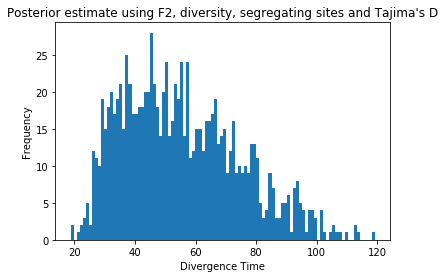

Acceptance probability : 0.1003


In [155]:
#4 Statistic Samples, Mahalanobis Distance
eps = 1
samples = []
for iteration in range(iterations):
    sim_stat = attempt1[0][iteration]
    if distance.mahalanobis(sim_stat,ref_stats,np.linalg.inv(cov)) < eps:
        samples.append(attempt1[1][iteration])
plt.hist(samples, bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Divergence Time')
plt.title("Posterior estimate using F2, diversity, segregating sites and Tajima's D")
plt.show()
print("Acceptance probability :",len(samples)/iterations)